Found 2064 NPZ files
Processed 0/2064 patients
Processed 100/2064 patients
Processed 200/2064 patients
Processed 300/2064 patients
Processed 400/2064 patients
Processed 500/2064 patients
Processed 600/2064 patients
Processed 700/2064 patients
Processed 800/2064 patients
Processed 900/2064 patients
Processed 1000/2064 patients
Processed 1100/2064 patients
Processed 1200/2064 patients
Processed 1300/2064 patients
Processed 1400/2064 patients
Processed 1500/2064 patients
Processed 1600/2064 patients
Processed 1700/2064 patients
Processed 1800/2064 patients
Processed 1900/2064 patients
Processed 2000/2064 patients
Loaded dataset shape: (539719, 1024, 1)
Train: 431775, Test: 107944


2025-10-11 13:25:19.204081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-11 13:25:19.225838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-11 13:25:19.234556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-11 13:25:19.239244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/200


2025-10-11 13:25:27.750099: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-10-11 13:25:28.633619: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-10-11 13:25:28.633942: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-10-11 13:25:28.633958: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-10-11 13:25:28.634212: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-10-11 13:25:28.634285: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-10-11 13:25:29.442100: I tensorflow/stream_executor/cuda/c

6072/6072 [==============================] - 166s 26ms/step - loss: 876.6984 - sbp_output_loss: 684.2658 - dbp_output_loss: 192.4336 - sbp_output_mae: 20.2604 - dbp_output_mae: 10.5795 - val_loss: 272.5068 - val_sbp_output_loss: 202.1430 - val_dbp_output_loss: 70.3638 - val_sbp_output_mae: 10.7735 - val_dbp_output_mae: 6.2506 - lr: 0.0010
Epoch 2/200
6072/6072 [==============================] - 157s 26ms/step - loss: 563.4197 - sbp_output_loss: 432.0546 - dbp_output_loss: 131.3643 - sbp_output_mae: 16.3464 - dbp_output_mae: 8.8611 - val_loss: 223.6718 - val_sbp_output_loss: 167.3306 - val_dbp_output_loss: 56.3413 - val_sbp_output_mae: 9.8779 - val_dbp_output_mae: 5.3812 - lr: 0.0010
Epoch 3/200
6072/6072 [==============================] - 158s 26ms/step - loss: 470.4707 - sbp_output_loss: 359.3558 - dbp_output_loss: 111.1150 - sbp_output_mae: 14.8785 - dbp_output_mae: 8.1256 - val_loss: 150.8391 - val_sbp_output_loss: 105.3453 - val_dbp_output_loss: 45.4938 - val_sbp_output_mae: 7.7323

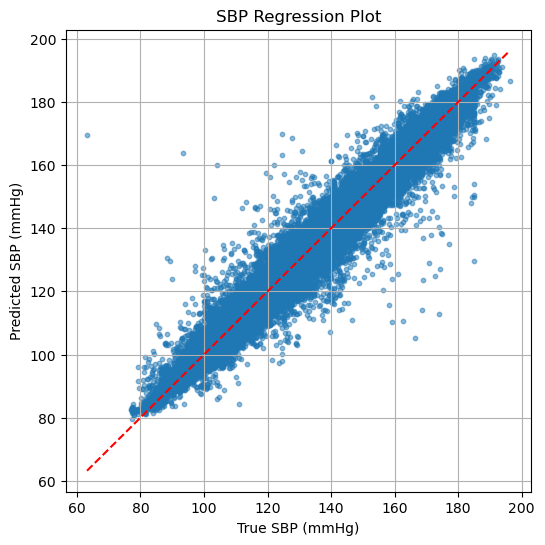

MemoryError: Unable to allocate 86.8 GiB for an array with shape (107944, 107944) and data type float64

In [ ]:
"""
Cuffless Blood Pressure Estimation using CNN-BiLSTM-Attention Model
Generate regression + Bland–Altman plots
"""

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Dense, Dropout, Bidirectional, LSTM, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ------------------ ATTENTION LAYER ------------------
class AttentionLayer(Layer):
    def __init__(self, units=128, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weights',
                                shape=(input_shape[-1], self.units),
                                initializer='random_normal',
                                trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                shape=(self.units,),
                                initializer='zeros',
                                trainable=True)
        self.u = self.add_weight(name='attention_context',
                                shape=(self.units,),
                                initializer='random_normal',
                                trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, inputs):
        uit = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.nn.softmax(ait, axis=1)
        ait = tf.expand_dims(ait, axis=-1)
        weighted_input = inputs * ait
        output = tf.reduce_sum(weighted_input, axis=1)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
    
    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units})
        return config

# ------------------ PREPROCESSING ------------------
def preprocess_ppg_signal(ppg_signal, sampling_rate=125):
    time_axis = np.arange(len(ppg_signal))
    coeffs = np.polyfit(time_axis, ppg_signal, 1)
    trend = np.polyval(coeffs, time_axis)
    detrended_signal = ppg_signal - trend
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_signal = scaler.fit_transform(detrended_signal.reshape(-1, 1)).flatten()
    return normalized_signal

def extract_windows(ppg_signal, abp_signal, window_size=8.192, overlap=0.75, sampling_rate=125):
    window_samples = int(window_size * sampling_rate)
    step_samples = int(window_samples * (1 - overlap))
    ppg_windows, sbp_targets, dbp_targets = [], [], []

    for start_idx in range(0, len(ppg_signal) - window_samples + 1, step_samples):
        end_idx = start_idx + window_samples
        ppg_window = ppg_signal[start_idx:end_idx]
        abp_window = abp_signal[start_idx:end_idx]

        peaks, _ = signal.find_peaks(abp_window, height=np.mean(abp_window), distance=int(0.6*sampling_rate))
        troughs, _ = signal.find_peaks(-abp_window, height=-np.mean(abp_window), distance=int(0.6*sampling_rate))

        if len(peaks) > 0 and len(troughs) > 0:
            sbp = np.mean(abp_window[peaks])
            dbp = np.mean(abp_window[troughs])
        else:
            sbp = np.max(abp_window)
            dbp = np.min(abp_window)

        ppg_windows.append(ppg_window)
        sbp_targets.append(sbp)
        dbp_targets.append(dbp)

    return np.array(ppg_windows), np.array(sbp_targets), np.array(dbp_targets)

def load_patient_data(npz_file_path):
    try:
        data = np.load(npz_file_path)
        return data['ppg'], data['abp']
    except:
        print(f"Error loading {npz_file_path}")
        return None, None

def load_dataset(data_folder_path):
    npz_files = glob.glob(os.path.join(data_folder_path, "*.npz"))
    print(f"Found {len(npz_files)} NPZ files")
    all_ppg_windows, all_sbp_targets, all_dbp_targets = [], [], []

    for i, npz_file in enumerate(npz_files):
        ppg, abp = load_patient_data(npz_file)
        if ppg is None or abp is None or len(ppg) < 1024:
            continue
        ppg_processed = preprocess_ppg_signal(ppg)
        ppg_windows, sbp_targets, dbp_targets = extract_windows(ppg_processed, abp)
        all_ppg_windows.extend(ppg_windows)
        all_sbp_targets.extend(sbp_targets)
        all_dbp_targets.extend(dbp_targets)
        if i % 100 == 0:
            print(f"Processed {i}/{len(npz_files)} patients")

    X = np.array(all_ppg_windows).reshape(-1, 1024, 1)
    y_sbp = np.array(all_sbp_targets)
    y_dbp = np.array(all_dbp_targets)
    print(f"Loaded dataset shape: {X.shape}")
    return X, y_sbp, y_dbp

# ------------------ MODEL ------------------
def create_cnn_bilstm_attention_model(input_shape=(1024, 1)):
    inputs = Input(shape=input_shape, name='ppg_input')
    
    # CNN layers for feature extraction
    # First CNN layer
    x = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.2)(x)
    
    # Second CNN layer  
    x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.2)(x)
    
    # Third CNN layer
    x = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.2)(x)
    
    # BiLSTM layers
    # First BiLSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = layers.BatchNormalization()(x)
    # Second BiLSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = layers.BatchNormalization()(x)
    # Attention mechanism
    attention_output = AttentionLayer(units=128)(x)
    
    # Dense layers for final prediction
    x = Dense(64, activation='relu')(attention_output)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output layers for SBP and DBP
    sbp_output = Dense(1, activation='linear', name='sbp_output')(x)
    dbp_output = Dense(1, activation='linear', name='dbp_output')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=[sbp_output, dbp_output])
    
    return model

# ------------------ PLOTS ------------------
def plot_regression(y_true, y_pred, label):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel(f"True {label} (mmHg)")
    plt.ylabel(f"Predicted {label} (mmHg)")
    plt.title(f"{label} Regression Plot")
    plt.grid(True)
    plt.show()

def plot_bland_altman(y_true, y_pred, label):
    mean_vals = (y_true + y_pred) / 2
    diff = y_true - y_pred
    md = np.mean(diff)
    sd = np.std(diff)
    plt.figure(figsize=(6,4))
    plt.scatter(mean_vals, diff, s=10, alpha=0.5)
    plt.axhline(md, color='r', linestyle='--', label='Mean Diff')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--', label='±1.96 SD')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.xlabel(f"Mean {label} (mmHg)")
    plt.ylabel(f"Difference (True - Pred)")
    plt.title(f"{label} Bland–Altman Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------ MAIN ------------------
def main():
    data_folder = r"/preprocessed_patients"
    X, y_sbp, y_dbp = load_dataset(data_folder)

    # 1-fold split: 80% train, 20% test
    X_train, X_test, y_sbp_train, y_sbp_test, y_dbp_train, y_dbp_test = train_test_split(
        X, y_sbp, y_dbp, test_size=0.2, random_state=42
    )

    print(f"Train: {len(X_train)}, Test: {len(X_test)}")

    model = create_cnn_bilstm_attention_model(input_shape=(X.shape[1], X.shape[2]))
    model.compile(
        optimizer=Adam(1e-3),
        loss={'sbp_output': 'mse', 'dbp_output': 'mse'},
        metrics={'sbp_output': 'mae', 'dbp_output': 'mae'}
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
        ModelCheckpoint("best_model_fold1.h5", save_best_only=True)
    ]

    history = model.fit(
        X_train,
        {'sbp_output': y_sbp_train, 'dbp_output': y_dbp_train},
        validation_split=0.1,
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    # Load best model
    model = tf.keras.models.load_model("best_model_fold1.h5", custom_objects={'AttentionLayer': AttentionLayer})
    sbp_pred, dbp_pred = model.predict(X_test)

    sbp_mae = mean_absolute_error(y_sbp_test, sbp_pred)
    dbp_mae = mean_absolute_error(y_dbp_test, dbp_pred)
    print(f"SBP MAE: {sbp_mae:.2f}, DBP MAE: {dbp_mae:.2f}")

    # --- Regression and Bland–Altman plots ---
    plot_regression(y_sbp_test, sbp_pred, "SBP")
    plot_bland_altman(y_sbp_test, sbp_pred, "SBP")

    plot_regression(y_dbp_test, dbp_pred, "DBP")
    plot_bland_altman(y_dbp_test, dbp_pred, "DBP")

if __name__ == "__main__":
    main()
